## Accelerate Inference: Neural Network Pruning

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.10.0


In [2]:
# untar
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

x train_images.pkl
x train_labels.pkl
x val_images.pkl
x val_labels.pkl


In [3]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [103]:
def get_indices_of_k_smallest(arr, k):
        idx = np.argpartition(arr.ravel(), k)
        return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])
        # if you want it in a list of indices . . . 
        # return np.array(np.unravel_index(idx, arr.shape))[:, range(k)].transpose().tolist()

c = len(model.layers)
for i in range(c):
    name = model.layers[i].name
    if(name.startswith("dense")):
        w1 = model.layers[i].get_weights()[0]
        b = model.layers[i].get_weights()[1]
        print(w1.shape, b.shape)
        indices = get_indices_of_k_smallest(w1, 4)
        print(indices)
        print(w1[indices[0]].shape, w1[indices[1]].shape)
    

for i in range(len(indices[0])):
    print(indices[0][i], indices[1][i])


(1024, 512) (512,)
(array([235, 481, 960, 491]), array([218, 217, 192, 218]))
(4, 512) (4, 512)
(512, 5) (5,)
(array([315,  42,  15, 477]), array([4, 4, 4, 4]))
(4, 5) (4, 5)
315 4
42 4
15 4
477 4


In [5]:
# you can use the default hyper-parameters for training, 
# and val accuracy ~59% after 25 epochs and > 63% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50, 
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

Epoch 1/50


2022-11-30 15:40:53.381753: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/kelaba/mambaforge/envs/bioimage/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


703/703 [==============================] - 18s 25ms/step - loss: 1.5124 - accuracy: 0.3074 - val_loss: 1.3712 - val_accuracy: 0.4127
Epoch 2/50
703/703 [==============================] - 14s 19ms/step - loss: 1.3367 - accuracy: 0.4265 - val_loss: 1.2554 - val_accuracy: 0.4760
Epoch 3/50
703/703 [==============================] - 13s 18ms/step - loss: 1.2749 - accuracy: 0.4604 - val_loss: 1.2234 - val_accuracy: 0.4871
Epoch 4/50
703/703 [==============================] - 13s 18ms/step - loss: 1.2295 - accuracy: 0.4894 - val_loss: 1.1703 - val_accuracy: 0.5125
Epoch 5/50
703/703 [==============================] - 16s 23ms/step - loss: 1.1937 - accuracy: 0.5098 - val_loss: 1.1959 - val_accuracy: 0.4954
Epoch 6/50
703/703 [==============================] - 18s 26ms/step - loss: 1.1630 - accuracy: 0.5265 - val_loss: 1.1278 - val_accuracy: 0.5366
Epoch 7/50
703/703 [==============================] - 20s 29ms/step - loss: 1.1319 - accuracy: 0.5427 - val_loss: 1.0912 - val_accuracy: 0.5537
Epo

In [6]:
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 1s 22ms/step - loss: 0.7558 - accuracy: 0.7164


In [170]:
import copy
# perform pruning here
'''
f1 pruning
stage wise pruning - set a single pruning rate for all layers in one stage
'''
def prune(model, conv_prune_rate, dense_prune_rate):

    #print("hello from pruning")
    # print(model.layers)

    conv_indices = [] #store conv layer indices
    dense_indices = [] #store dense layer indices

    c = len(model.layers)
    for i in range(c):
        name = model.layers[i].name
        if(name.startswith("conv")):
            conv_indices.append(i)

        if(name == "dense"):
            dense_indices.append(i)

    #additional: magnitude based pruning on the first dense layer
    for i in dense_indices:
        layer = model.layers[i]

        w, b = layer.get_weights()[0], layer.get_weights()[1]
        total = w.shape[0] * w.shape[1]
        num_delete = (int(total * dense_prune_rate))
        # print("num to delete: ", num_delete)
        indices = get_indices_of_k_smallest(w, num_delete)
        
        for j in range(len(indices[0])):
            x, y = indices[0][j], indices[1][j]
            w[x][y] = 0
        model.layers[i].set_weights([w,b]) 

    

    #for i in indices:
    for i in conv_indices: # loop thru convs
        layer = model.layers[i]
        w = layer.get_weights()[0] # shape h,w,c,f
        num_filters = w.shape[-1]
        # print(w.shape, "num filters: ", num_filters)

        weights_dict = {}
        num_delete = (int(num_filters * conv_prune_rate))
        #print("num filters to delete: ", num_delete)

        l1_list = [] #store l1s
        for j in range(num_filters):
            l1 = np.sum(abs(w[:,]))
            filt = f"{j}"
            weights_dict[filt] = l1
            l1_list.append(l1)
        
        weights_dict_sort = sorted(weights_dict.items(), key = lambda k: k[1])
        # print(weights_dict_sort)

        delete_indices = []
        for l in range(num_delete):
            delete_indices.append((int)(weights_dict_sort[l][0]))
        
        for k in delete_indices:
            # print(layer.weights[0][:,:,:,i].shape)
            model.layers[i].weights[0][:,:,:,k].assign(0)
            # layer.weights[1][:].assign(0) #assign bias to 0?

# get the weights 
# weights = model.get_weights()

# you can use set_weights() to set some weights to zero, e.g.,
# some references for pruning techniques: https://arxiv.org/pdf/1810.05270v2.pdf, https://arxiv.org/pdf/2001.04062.pdf

# weights[7][:10]=0
# model.set_weights(weights)


In [299]:
#copy model + prune
model2 = keras.models.clone_model(model)
model2.build() # replace 10 with number of variables in input layer
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.set_weights(model.get_weights())

prune(model2, 0.7, 0.0)

c = len(model2.layers)
total_weights = 0
zero_weights = 0
all_model2_weights = model2.get_weights()
for weight in all_model2_weights:
  total_weights += weight.size
  zero_weights += np.sum(weight == 0)


print(total_weights, zero_weights, zero_weights/total_weights)

592933 44946 0.07580283101126097


In [300]:
# evaluate again to see how the accuracy changes
results = model2.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 0s 17ms/step - loss: 1.7600 - accuracy: 0.1952


In [301]:
#train again with pruned

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(train_images, train_labels, batch_size=32, epochs=50, 
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

Epoch 1/50
703/703 [==============================] - 14s 20ms/step - loss: 1.3445 - accuracy: 0.4255 - val_loss: 1.1890 - val_accuracy: 0.5093
Epoch 2/50
703/703 [==============================] - 13s 19ms/step - loss: 1.2067 - accuracy: 0.5034 - val_loss: 1.1383 - val_accuracy: 0.5414
Epoch 3/50
703/703 [==============================] - 13s 18ms/step - loss: 1.1451 - accuracy: 0.5373 - val_loss: 1.0648 - val_accuracy: 0.5743
Epoch 4/50
703/703 [==============================] - 13s 19ms/step - loss: 1.1019 - accuracy: 0.5554 - val_loss: 1.0342 - val_accuracy: 0.5905
Epoch 5/50
703/703 [==============================] - 15s 21ms/step - loss: 1.0723 - accuracy: 0.5679 - val_loss: 1.0022 - val_accuracy: 0.6067
Epoch 6/50
703/703 [==============================] - 22s 31ms/step - loss: 1.0336 - accuracy: 0.5927 - val_loss: 0.9600 - val_accuracy: 0.6190
Epoch 7/50
703/703 [==============================] - 20s 29ms/step - loss: 1.0031 - accuracy: 0.6017 - val_loss: 0.9519 - val_accuracy:

In [316]:
#before pruning dense
results = model2.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 0s 17ms/step - loss: 0.7342 - accuracy: 0.7200


In [358]:
model3 = keras.models.clone_model(model2)
model3.build() # replace 10 with number of variables in input layer
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model3.set_weights(model2.get_weights())

prune(model3, 0.0, 0.25)

c = len(model3.layers)
total_weights = 0
zero_weights = 0
all_model3_weights = model3.get_weights()
for weight in all_model3_weights:
  total_weights += weight.size
  zero_weights += np.sum(weight == 0)


print(total_weights, zero_weights, zero_weights/total_weights)

592933 149036 0.25135386291537154


In [359]:
# evaluate again to see how the accuracy changes
results = model3.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 1s 27ms/step - loss: 1.1344 - accuracy: 0.6337


In [326]:
print(( 0.6008 + zero_weights/total_weights)/2)

0.7134508843326312


In [258]:
# you need to save the model's weights, naming it 'my_model_weights.h5'
model3.save_weights("my_model_weights_50_35.h5")

# # running this cell will immediately download a file called 'my_model_weights.h5'
# from google.colab import files
# files.download("my_model_weights.h5")

In [360]:
#accuracy vs sparsity curve:
spa = [0.05711, 0.0674545016, 0.072357, 0.077791, 0.08468, 0.089585163, 0.095019, 0.09921, 0.105355]
acc = [0.7434, 0.7267, 0.7315, 0.7347, 0.7156, 0.7121, 0.7109, 0.6582, 0.6235]

spa_50 = [0.019823487645315743, 0.0640342163448484, 0.10824494504438106, 0.15245736027510698, 0.19666808897463964, 0.24088050420536553, 0.2850912329048982, 0.32930196160443087]
acc_50 = [0.7323, 0.6954, 0.6752, 0.6463, 0.6368, 0.6135, 0.6166, 0.6135]

spa_70 = [0.030296846355321764, 0.11871830375438709, 0.20714144768464565, 0.25135386291537154, 0.2955645916149042, 0.33977532031443686, 0.3839877355451628, 0.4724108794754213, 0.5608323368744866]
acc_70 = [0.7200, 0.6669, 0.6475, 0.6337, 0.6206, 0.6139, 0.6087, 0.6063, 0.6079]


In [42]:
import matplotlib.pyplot as plt

In [59]:
mag_spar=[0.0019951664016001807, 0.012362273646432227, 0.022729380891264275, 0.03455702414944015, 0.044924131394272204, 0.05728640504070443, 0.06765351228553648, 0.07802061953036853, 0.08984826278854441, 0.10021537003337645, 0.10632229948409011]

mag_acc=[0.7017821669578552, 0.7152475118637085, 0.6914851665496826, 0.6716831922531128, 0.6685148477554321, 0.6273267269134521, 0.5948514938354492, 0.569504976272583, 0.5172277092933655, 0.437227725982666, 0.19207920134067535]

ThiNet_acc = [0.6828, 0.6760, 0.66376239, 0.6788, 0.6246, 0.635247528553009, 0.6368317008018494, 0.6190099120140076, 0.6455445289611816, 0.5916831493377686]
ThiNet_spar = [0.358563, 0.360, 0.361447246, 0.403465, 0.40432898827, 0.53932906416, 0.540771048, 0.5853882310480274, 0.5867239637530716, 0.6288484533665692]

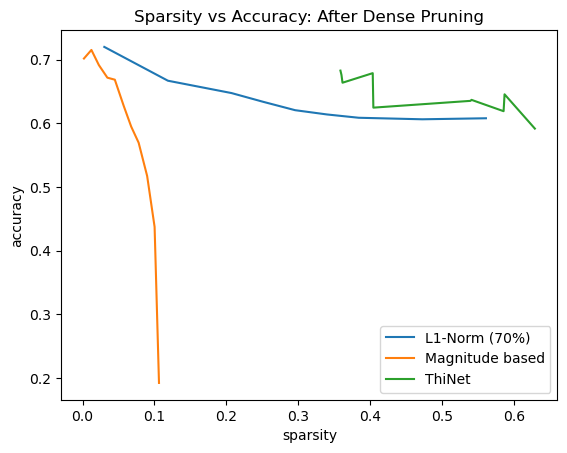

In [364]:
plt.plot(spa_70, acc_70)
plt.plot(mag_spar, mag_acc)
plt.plot(ThiNet_spar, ThiNet_acc)
plt.xlabel('sparsity')
plt.ylabel('accuracy')
plt.title('Sparsity vs Accuracy: After Dense Pruning')
plt.legend(['L1-Norm (70%)', 'Magnitude based', 'ThiNet'])
plt.show()